# 01_fetch_prometheus

Первичный запрос данных из Prometheus и первичный EDA.

In [1]:
from src.data_loader import fetch_frame
df = fetch_frame()
# df = fetch_frame(
#     use_cache=True,
#     cache_filename="my_custom_data.parquet"
# )
df.head()

df.info()

df.describe()

df.isnull().sum()


Fetching common_delay_p90 from Prometheus for chunk: 2025-04-27 21:00:00 to 2025-04-28 01:10:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 01:10:00 to 2025-04-28 05:20:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 05:20:00 to 2025-04-28 09:30:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 09:30:00 to 2025-04-28 13:40:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 13:40:00 to 2025-04-28 17:50:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 17:50:00 to 2025-04-28 22:00:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 22:00:00 to 2025-04-29 02:10:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-29 02:10:00 to 2025-04-29 06:20:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-29 06:20:00 to 2025-04-29 10:30:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-29 10:30:00 to 2025-04-29 14:40:00
Fetching common_delay_p90 from Prometheu

common_delay_p90    2
dtype: int64

<Axes: xlabel='ts'>

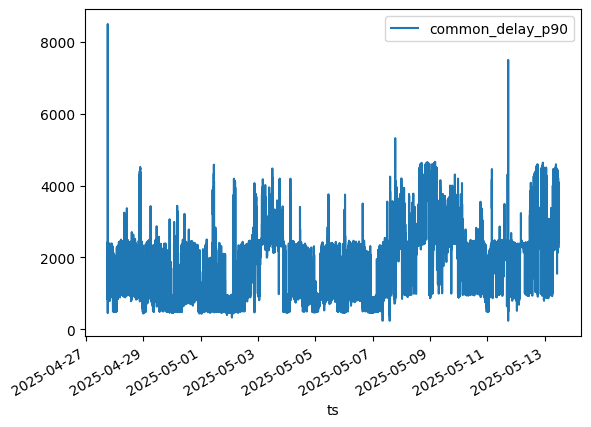

In [2]:
df.plot()

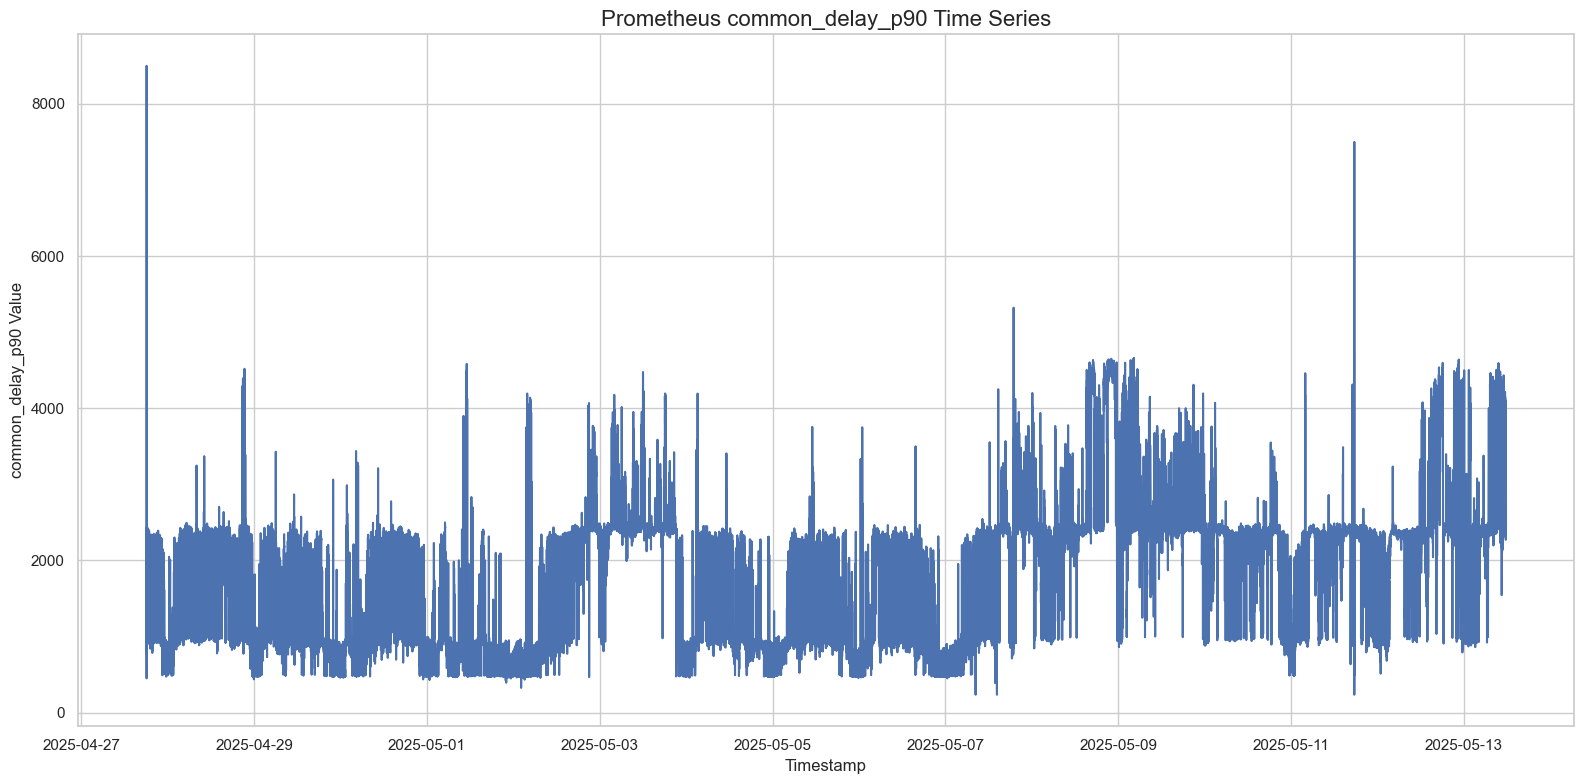

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))

# Plot the common_delay_p90 series
sns.lineplot(data=df['common_delay_p90'])
plt.title('Prometheus common_delay_p90 Time Series', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('common_delay_p90 Value', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## 1 hour resampled data

/var/folders/hz/g0q481y17153sdyxw9_71p380000gn/T/ipykernel_84414/2529452834.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['common_delay_p90'].resample('1H').mean().interpolate(method='time')


Hourly resampled data info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 378 entries, 2025-04-27 18:00:00 to 2025-05-13 11:00:00
Freq: h
Series name: common_delay_p90
Non-Null Count  Dtype  
--------------  -----  
378 non-null    float64
dtypes: float64(1)
memory usage: 5.9 KB

Missing values after resampling:
0


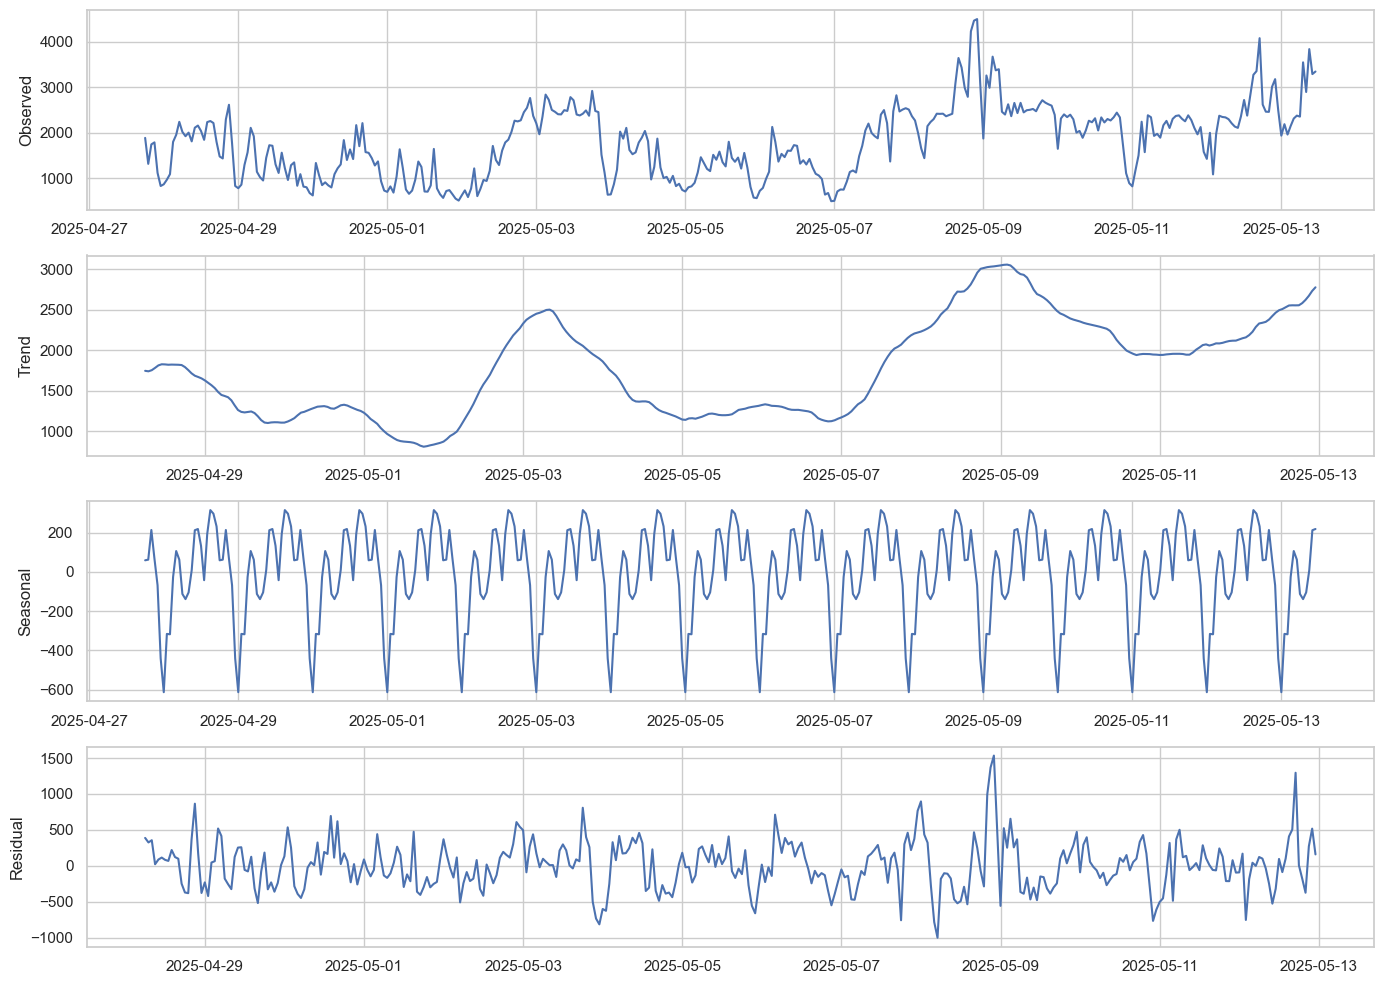

In [4]:

# Resample the data to an hourly frequency for easier analysis
df_hourly = df['common_delay_p90'].resample('1H').mean().interpolate(method='time')

print("Hourly resampled data info:")
df_hourly.info()
print("\nMissing values after resampling:")
print(df_hourly.isnull().sum())

# Perform seasonal decomposition (assuming daily seasonality for hourly data)
# Period for daily seasonality with hourly data is 24
decomposition = seasonal_decompose(df_hourly, model='additive', period=24)

# Plot decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

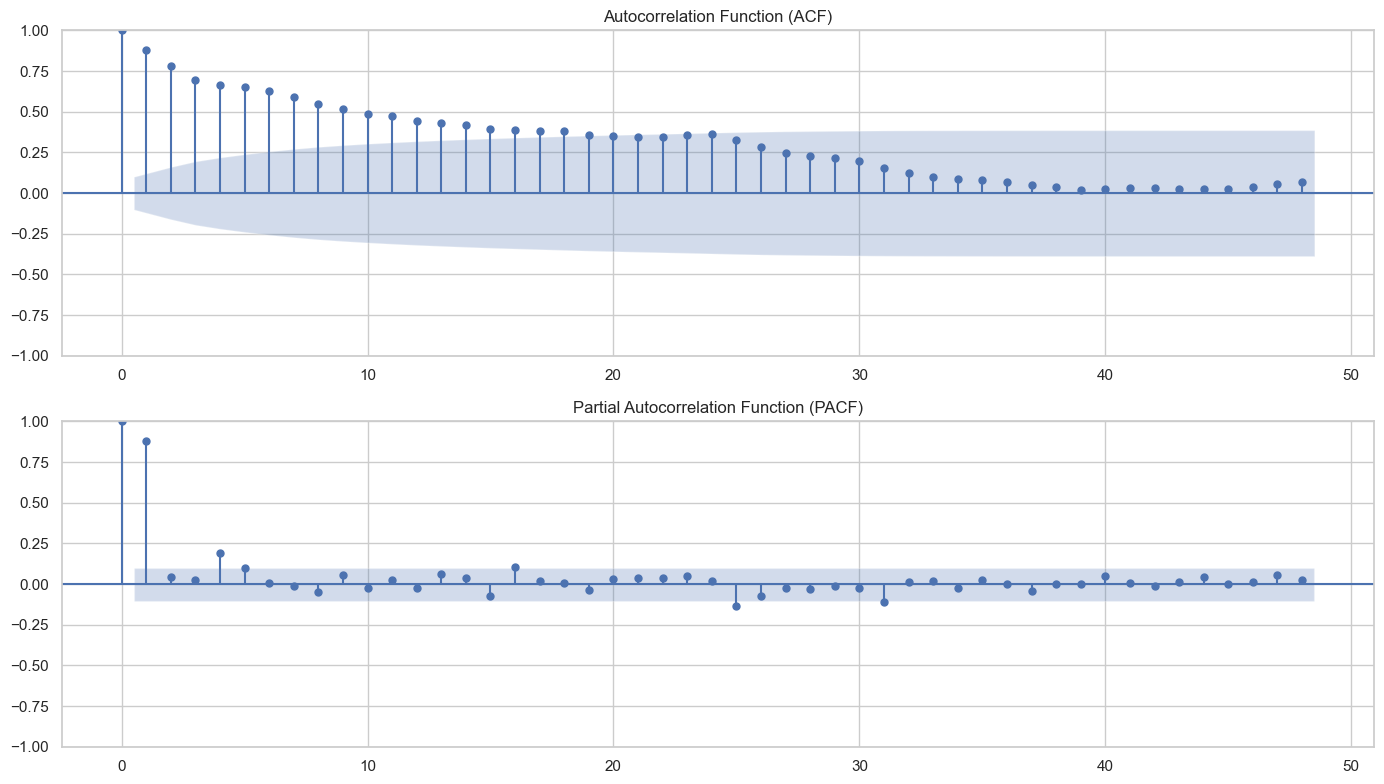

In [5]:
# Plot ACF and PACF to identify potential AR/MA components and seasonality
plt.figure(figsize=(14, 8))
plt.subplot(211)
plot_acf(df_hourly.dropna(), lags=48, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(df_hourly.dropna(), lags=48, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

## Анализ исходного временного ряда (без ресемплинга)

Анализируем оригинальные данные с интервалом 15 секунд - как есть.


In [32]:

# Базовая информация об исходном ряде
print("=== Информация о исходном временном ряде ===")
print(f"Общее количество точек: {len(df)}")
print(f"Период данных: {df.index.min()} - {df.index.max()}")
print(f"Временной интервал между точками: {df.index.to_series().diff().mode()[0]}")
print(f"Пропущенные значения: {df['common_delay_p90'].isnull().sum()}")

# Базовая статистика
print("\n=== Основная статистика ===")
print(df['common_delay_p90'].describe())

# Проверим частоту данных
time_diffs = df.index.to_series().diff().dropna()
print(f"\nЧастота данных:")
print(f"Медианный интервал: {time_diffs.median()}")
print(f"Минимальный интервал: {time_diffs.min()}")
print(f"Максимальный интервал: {time_diffs.max()}")
print(f"Стандартное отклонение интервалов: {time_diffs.std()}")


print("\nПроверка на дубликаты во временном индексе:")
print(f"Количество дубликатов в индексе: {df.index.duplicated().sum()}")
if df.index.duplicated().any():
    print("Внимание: Обнаружены дубликаты во временном индексе. Обрабатываю...")
    # Удаляем дубликаты, оставляя последнее значение, или усредняем
    df = df.loc[~df.index.duplicated(keep='last')] # или .mean() если усреднение
    # df = df.resample('15S').mean() # Альтернативный способ, если нужны все 15s интервалы, даже пропущенные
    print(f"Количество точек после обработки дубликатов: {len(df)}")


=== Информация о исходном временном ряде ===
Общее количество точек: 90643
Период данных: 2025-04-27 18:00:30 - 2025-05-13 11:41:00
Временной интервал между точками: 0 days 00:00:15
Пропущенные значения: 2

=== Основная статистика ===
count    90641.000000
mean      1802.349510
std        901.617551
min        235.000000
25%        922.395833
50%       2094.852941
75%       2382.755633
max       8500.000000
Name: common_delay_p90, dtype: float64

Частота данных:
Медианный интервал: 0 days 00:00:15
Минимальный интервал: 0 days 00:00:15
Максимальный интервал: 0 days 00:00:15
Стандартное отклонение интервалов: 0 days 00:00:00

Проверка на дубликаты во временном индексе:
Количество дубликатов в индексе: 0


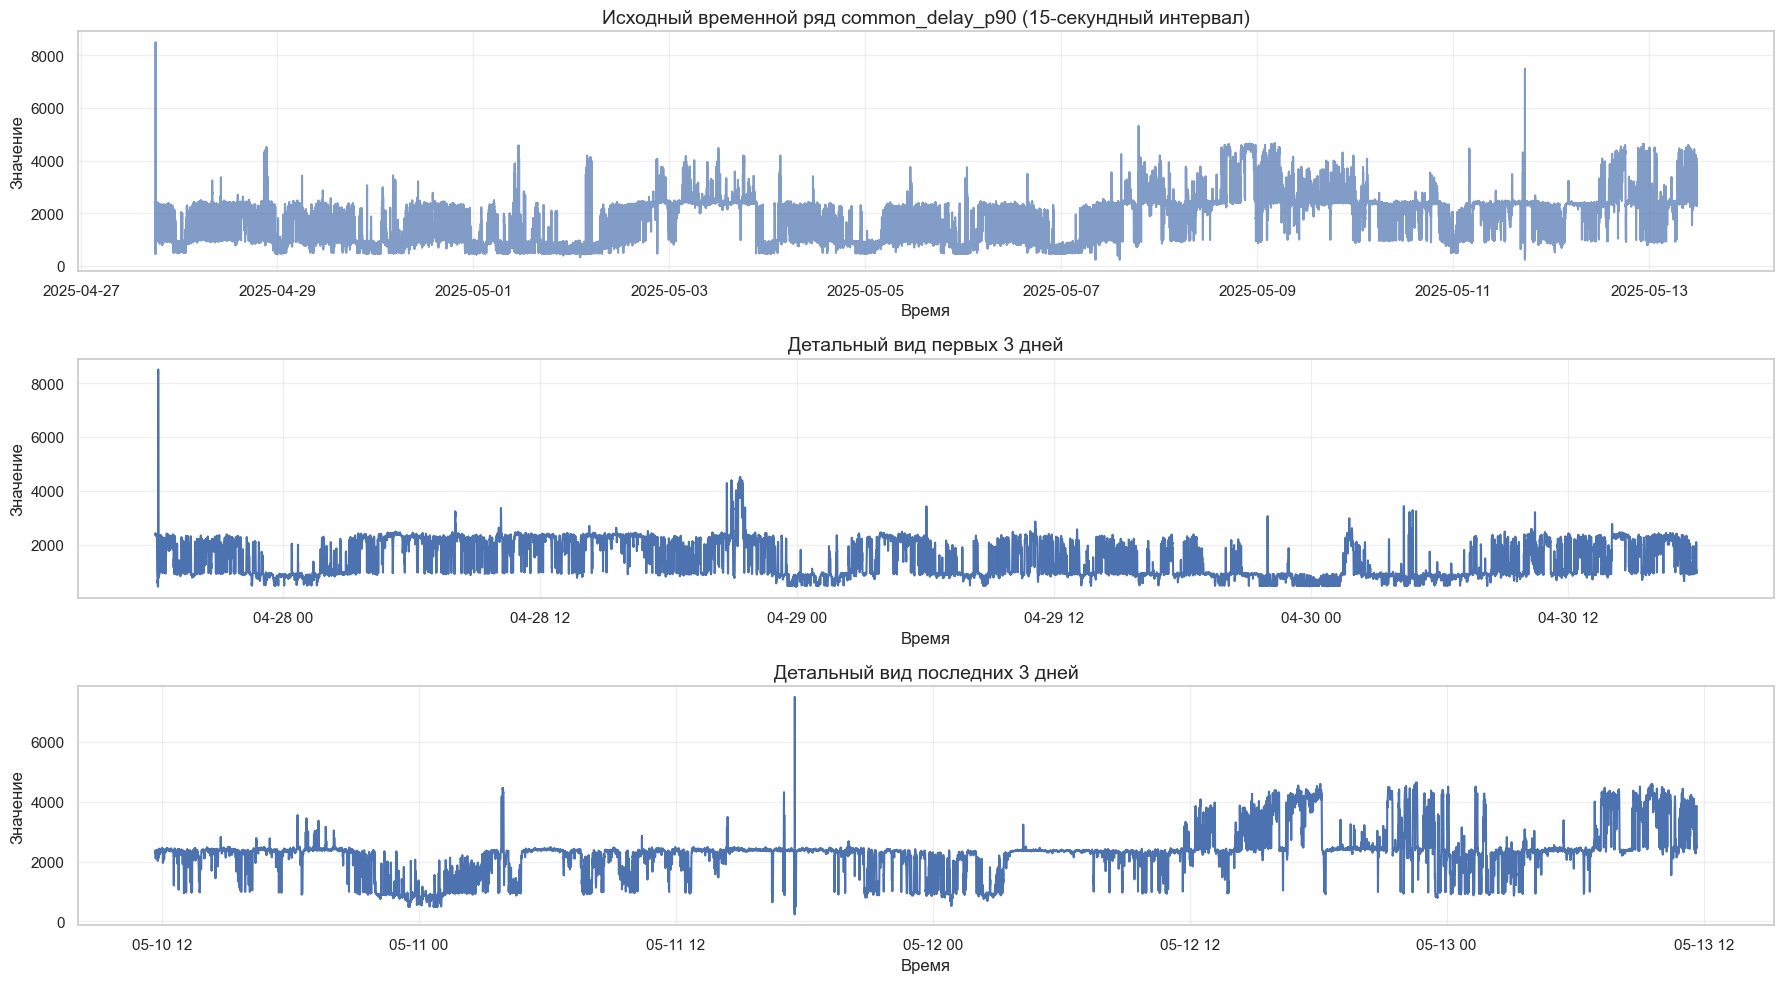

In [33]:
# Визуализация оригинального временного ряда
plt.figure(figsize=(18, 10))

# 1. Полный ряд
plt.subplot(3, 1, 1)
sns.lineplot(data=df, x=df.index, y='common_delay_p90', alpha=0.7)
plt.title('Исходный временной ряд common_delay_p90 (15-секундный интервал)', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(True, alpha=0.3)

# 2. Приближение на первые 3 дня
plt.subplot(3, 1, 2)
first_3_days = df.head(17280)  # примерно 3 дня * 24 часа * 240 точек в час
sns.lineplot(data=first_3_days, x=first_3_days.index, y='common_delay_p90')
plt.title('Детальный вид первых 3 дней', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(True, alpha=0.3)

# 3. Последние 3 дня
plt.subplot(3, 1, 3)
last_3_days = df.tail(17280)
sns.lineplot(data=last_3_days, x=last_3_days.index, y='common_delay_p90')
plt.title('Детальный вид последних 3 дней', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Используется подвыборка: усреднение до 1-минутного интервала
Размер выборки: 22662 точек
Период для сезонной декомпозиции: 1440


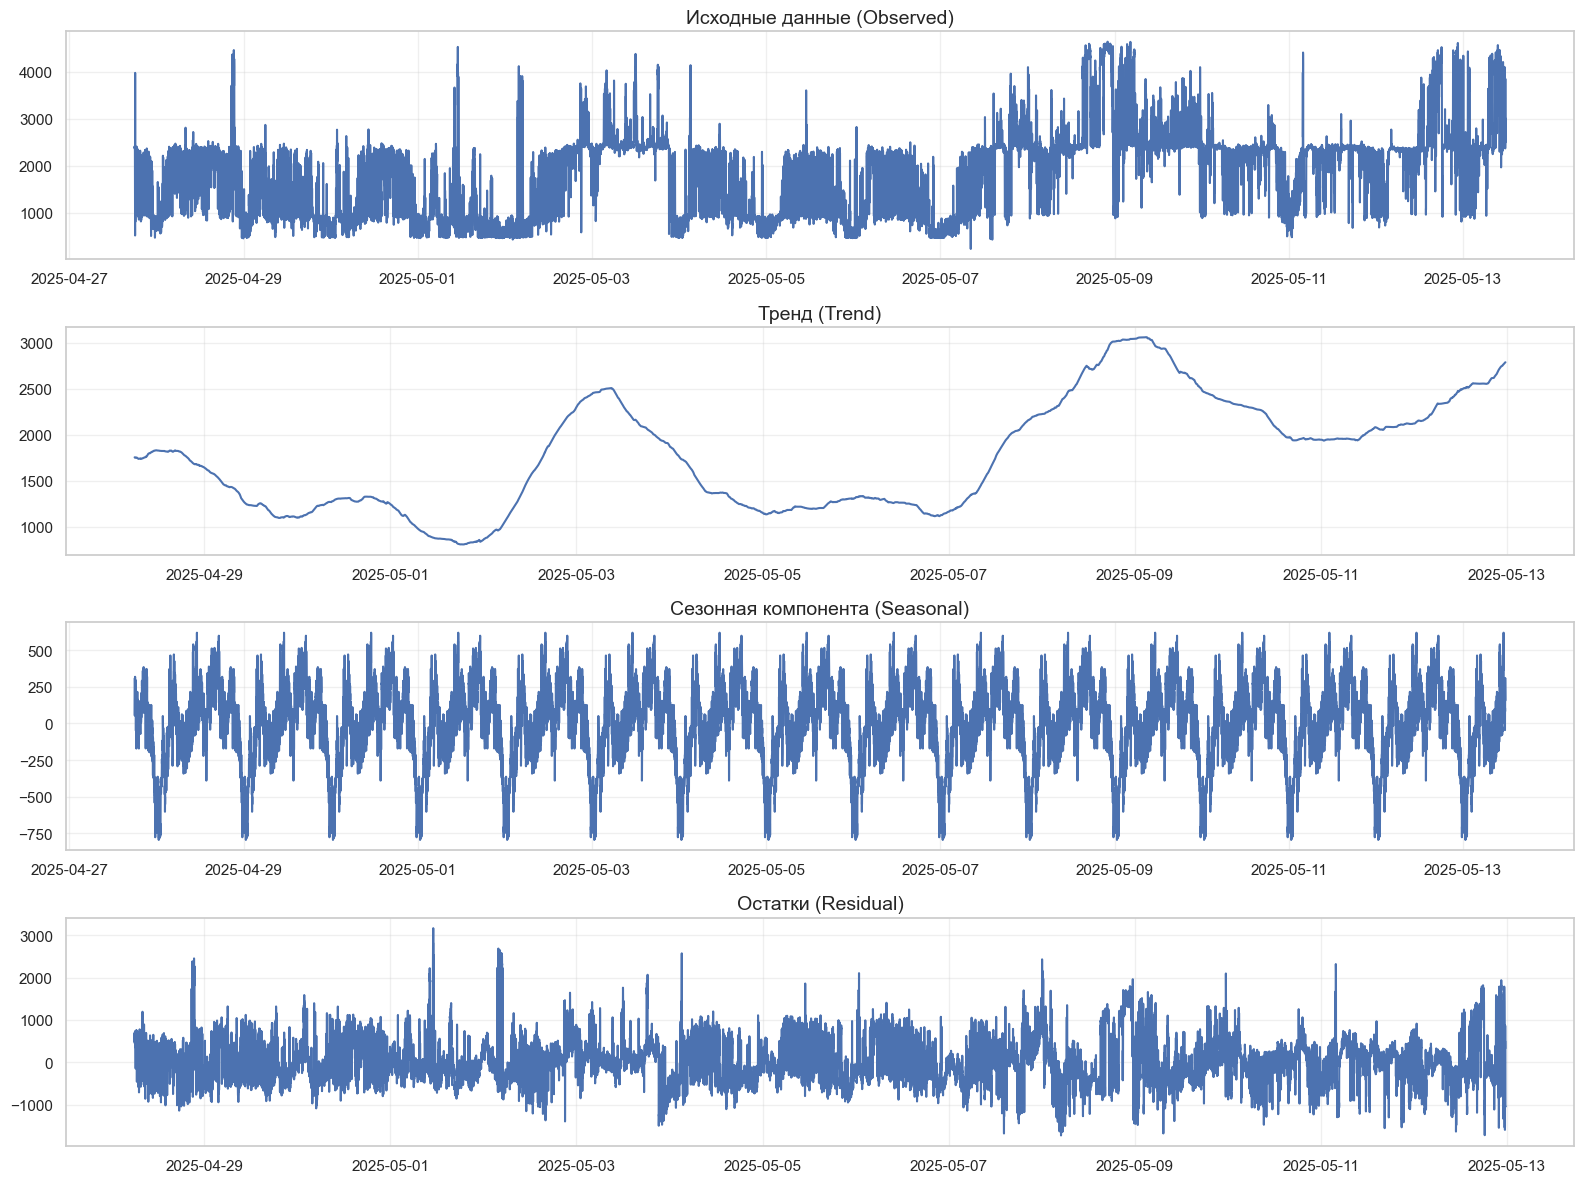

In [34]:
# Сезонная декомпозиция на исходных данных
# Для данных с интервалом 15 секунд:
# - В одном часе: 240 точек (3600 сек / 15 сек)
# - В одном дне: 5760 точек (24 * 240)

# Возьмем подвыборку для декомпозиции (слишком много данных для полного анализа)
# Возьмем данные за 7 дней для анализа недельной сезонности
week_data = df['common_delay_p90'].dropna()

# Если данных слишком много, усредним до 1-минутного интервала
if len(week_data) > 50000:
    # Усредняем каждые 4 точки для получения 1-минутных данных
    week_data_sample = week_data.resample('1min').mean()
    print(f"Используется подвыборка: усреднение до 1-минутного интервала")
    print(f"Размер выборки: {len(week_data_sample)} точек")
    period = 1440  # 24 часа * 60 минут = дневная сезонность
else:
    week_data_sample = week_data
    period = 5760  # дневная сезонность для 15-секундных данных

print(f"Период для сезонной декомпозиции: {period}")

# Сезонная декомпозиция
decomposition = seasonal_decompose(week_data_sample, model='additive', period=period)

# Визуализация декомпозиции
plt.figure(figsize=(16, 12))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Исходные данные (Observed)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Тренд (Trend)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Сезонная компонента (Seasonal)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Остатки (Residual)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


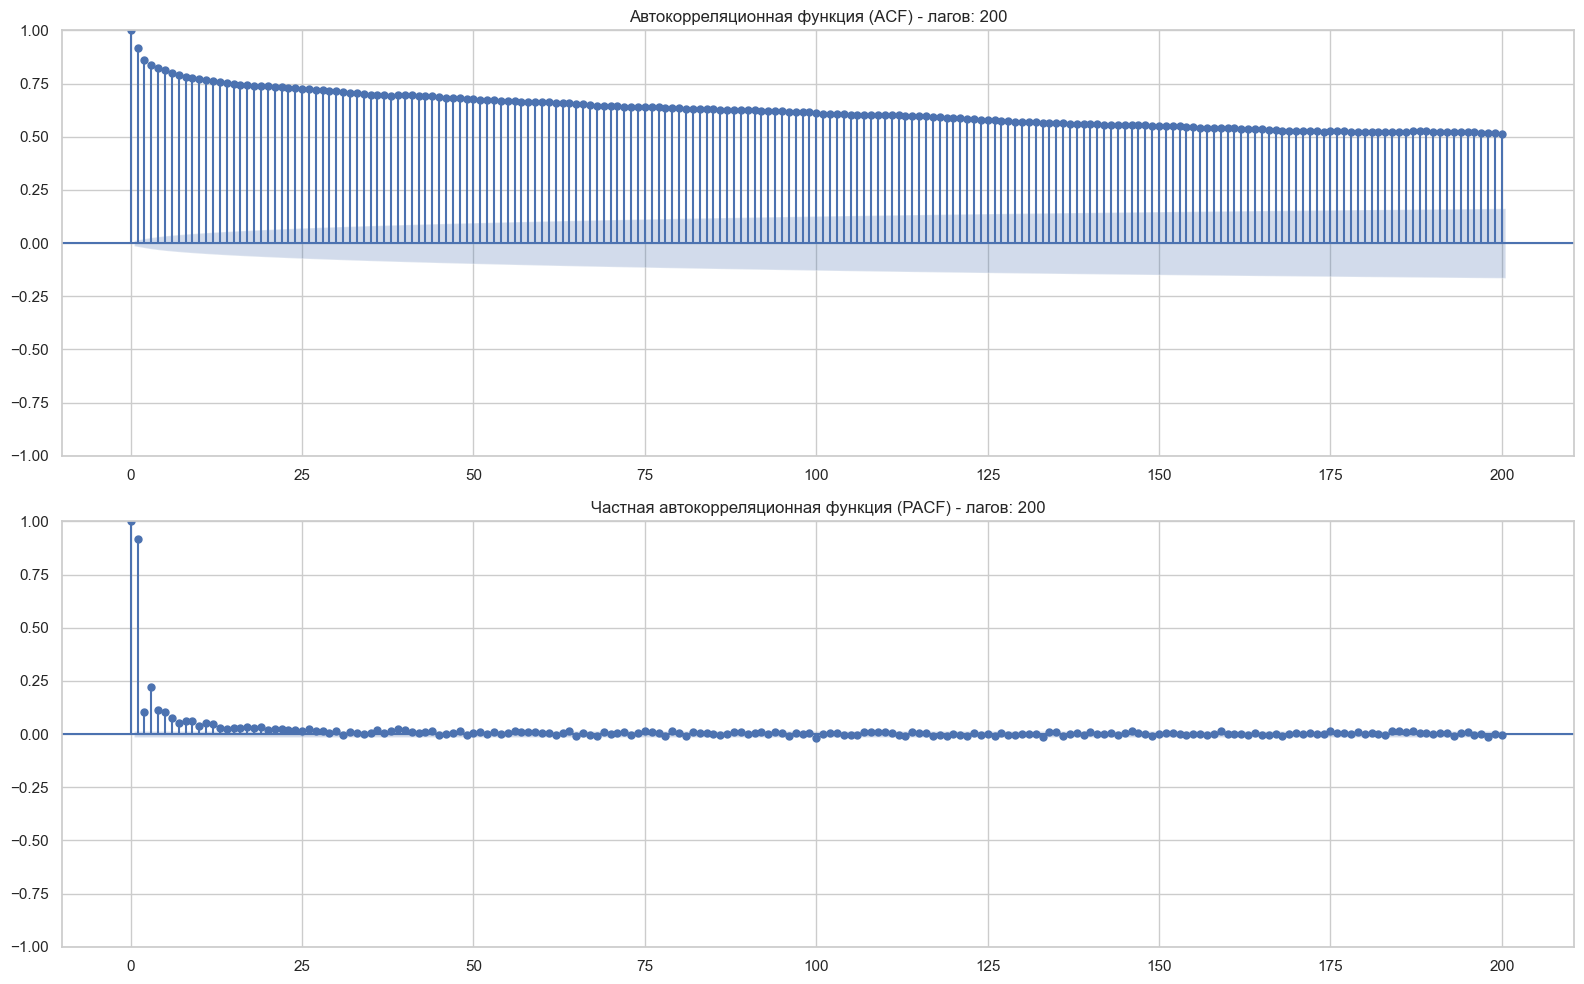

Анализ корреляций для 22662 точек данных
Максимальный лаг: 200 (примерно 3.3 часов для 1-минутных данных)


In [35]:
# ACF/PACF анализ для исходных данных
# Возьмем подвыборку для корреляционного анализа
sample_for_acf = week_data_sample.dropna()

# Лагов на 2 дня (для 1-минутных данных: 2880 точек, но ограничим до 200 для читаемости)
max_lags = min(200, len(sample_for_acf) // 4)

plt.figure(figsize=(16, 10))

# ACF
plt.subplot(2, 1, 1)
plot_acf(sample_for_acf, lags=max_lags, ax=plt.gca(), 
         title=f'Автокорреляционная функция (ACF) - лагов: {max_lags}')

# PACF
plt.subplot(2, 1, 2)
plot_pacf(sample_for_acf, lags=max_lags, ax=plt.gca(), 
          title=f'Частная автокорреляционная функция (PACF) - лагов: {max_lags}')

plt.tight_layout()
plt.show()

print(f"Анализ корреляций для {len(sample_for_acf)} точек данных")
print(f"Максимальный лаг: {max_lags} (примерно {max_lags/60:.1f} часов для 1-минутных данных)")


In [36]:
# Дополнительный статистический анализ
import numpy as np
from scipy import stats

raw_data = df['common_delay_p90'].dropna()

print("=== Расширенный статистический анализ ===")
print(f"Количество наблюдений: {len(raw_data)}")
print(f"Среднее: {raw_data.mean():.3f}")
print(f"Медиана: {raw_data.median():.3f}")
print(f"Стандартное отклонение: {raw_data.std():.3f}")
print(f"Коэффициент вариации: {(raw_data.std()/raw_data.mean())*100:.2f}%")
print(f"Асимметрия (skewness): {stats.skew(raw_data):.3f}")
print(f"Эксцесс (kurtosis): {stats.kurtosis(raw_data):.3f}")

# Процентили
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"\nПроцентили:")
for p in percentiles:
    value = np.percentile(raw_data, p)
    print(f"P{p}: {value:.3f}")

# Тест на нормальность
shapiro_stat, shapiro_p = stats.shapiro(raw_data[:5000])  # ограничиваем размер для теста
print(f"\nТест Шапиро-Уилка на нормальность (первые 5000 точек):")
print(f"Статистика: {shapiro_stat:.6f}, p-value: {shapiro_p:.6f}")
print(f"Данные {'НЕ ' if shapiro_p < 0.05 else ''}распределены нормально (α=0.05)")


=== Расширенный статистический анализ ===
Количество наблюдений: 90641
Среднее: 1802.350
Медиана: 2094.853
Стандартное отклонение: 901.618
Коэффициент вариации: 50.02%
Асимметрия (skewness): 0.476
Эксцесс (kurtosis): 0.076

Процентили:
P1: 475.000
P5: 497.857
P10: 764.286
P25: 922.396
P50: 2094.853
P75: 2382.756
P90: 2477.913
P95: 3364.286
P99: 4402.445

Тест Шапиро-Уилка на нормальность (первые 5000 точек):
Статистика: 0.831212, p-value: 0.000000
Данные НЕ распределены нормально (α=0.05)


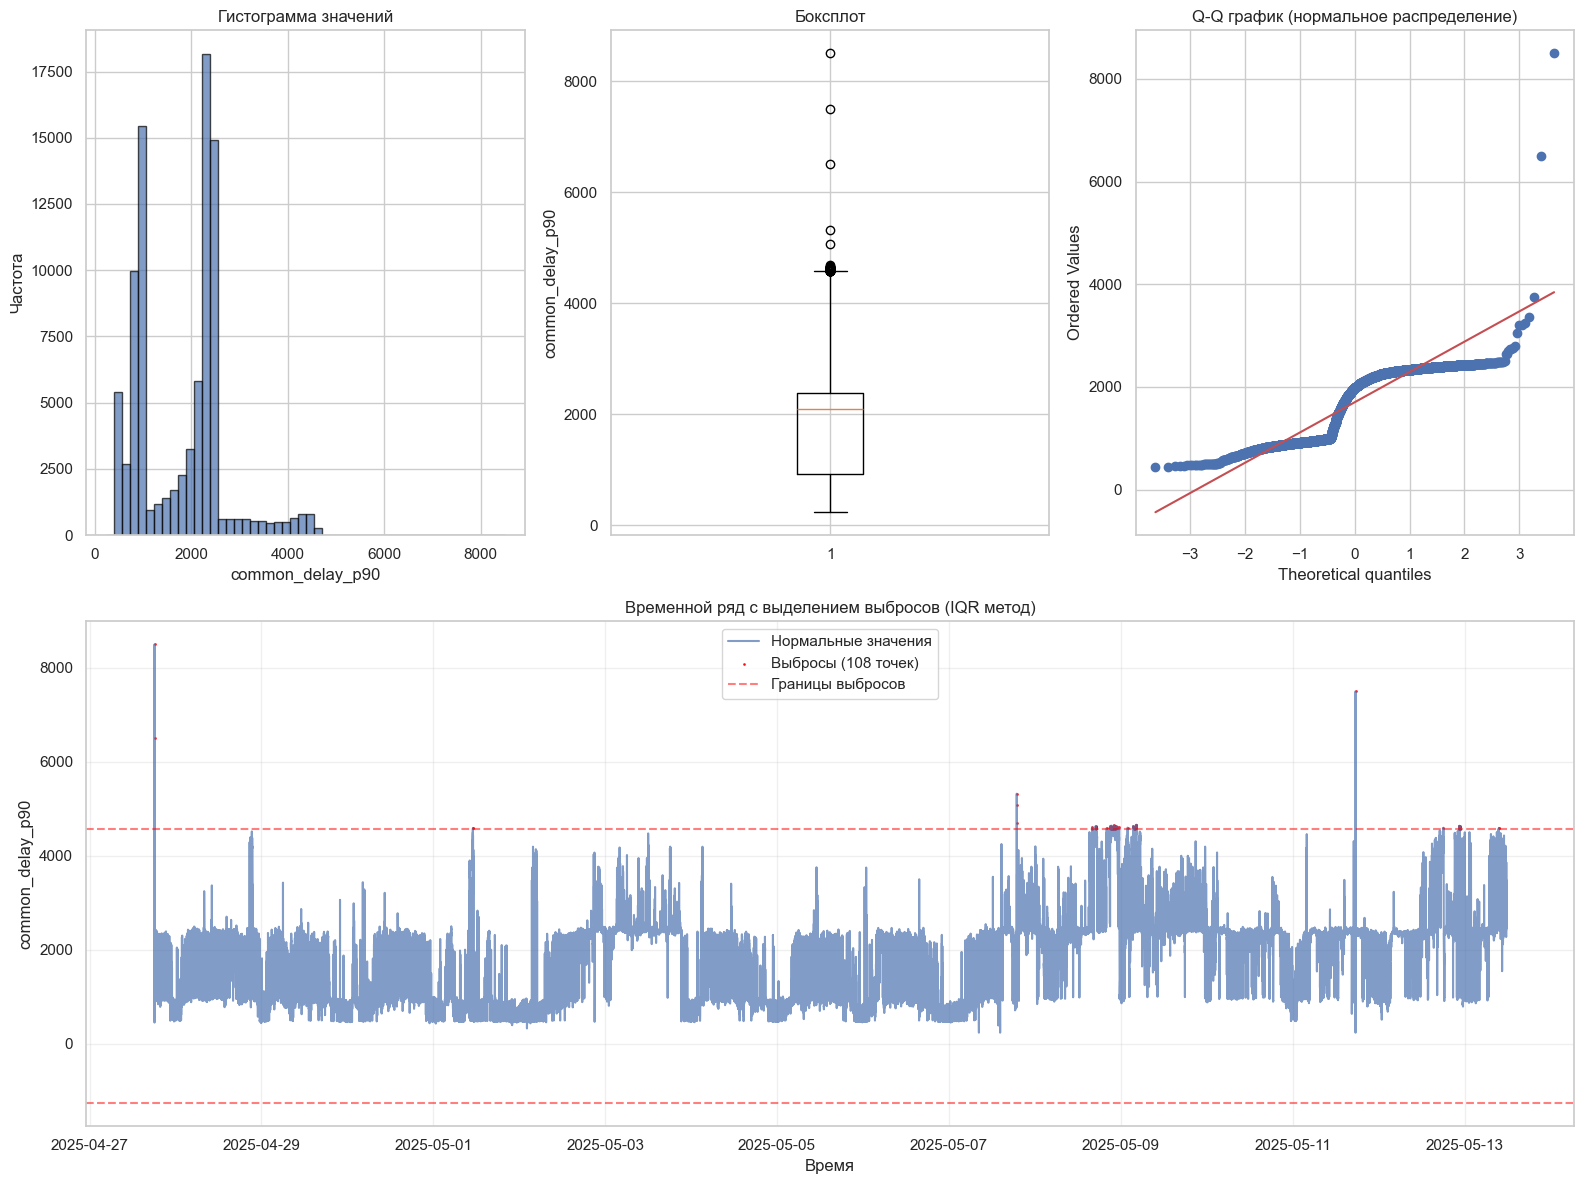

Выбросы (IQR метод):
Нижняя граница: -1268.144
Верхняя граница: 4573.295
Количество выбросов: 108 (0.12%)
Минимальный выброс: 4574.176
Максимальный выброс: 8500.000


In [37]:
# Распределение значений и выбросы
plt.figure(figsize=(16, 12))

# 1. Гистограмма
plt.subplot(2, 3, 1)
plt.hist(raw_data, bins=50, alpha=0.7, edgecolor='black')
plt.title('Гистограмма значений', fontsize=12)
plt.xlabel('common_delay_p90')
plt.ylabel('Частота')

# 2. Boxplot
plt.subplot(2, 3, 2)
plt.boxplot(raw_data)
plt.title('Боксплот', fontsize=12)
plt.ylabel('common_delay_p90')

# 3. Q-Q plot
plt.subplot(2, 3, 3)
stats.probplot(raw_data[:5000], dist="norm", plot=plt)
plt.title('Q-Q график (нормальное распределение)', fontsize=12)

# 4. Временной ряд с выделением выбросов
plt.subplot(2, 1, 2)
Q1 = raw_data.quantile(0.25)
Q3 = raw_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = raw_data[(raw_data < lower_bound) | (raw_data > upper_bound)]

plt.plot(raw_data.index, raw_data, alpha=0.7, label='Нормальные значения')
plt.scatter(outliers.index, outliers, color='red', alpha=0.8, s=1, label=f'Выбросы ({len(outliers)} точек)')
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.5, label=f'Границы выбросов')
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.5)
plt.title('Временной ряд с выделением выбросов (IQR метод)', fontsize=12)
plt.xlabel('Время')
plt.ylabel('common_delay_p90')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Выбросы (IQR метод):")
print(f"Нижняя граница: {lower_bound:.3f}")
print(f"Верхняя граница: {upper_bound:.3f}")
print(f"Количество выбросов: {len(outliers)} ({len(outliers)/len(raw_data)*100:.2f}%)")
print(f"Минимальный выброс: {outliers.min():.3f}")
print(f"Максимальный выброс: {outliers.max():.3f}")


In [38]:
# Анализ стационарности временного ряда
from statsmodels.tsa.stattools import adfuller, kpss

print("=== Тесты на стационарность ===")

# Тест Дики-Фуллера (ADF)
adf_result = adfuller(raw_data.dropna())
print("Расширенный тест Дики-Фуллера (ADF):")
print(f"ADF статистика: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")
print("Критические значения:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.3f}")
print(f"Ряд {'стационарен' if adf_result[1] < 0.05 else 'НЕ стационарен'} (α=0.05)")

print("\n" + "="*50)

# Тест KPSS
kpss_result = kpss(raw_data.dropna(), regression='c')
print("Тест KPSS:")
print(f"KPSS статистика: {kpss_result[0]:.6f}")
print(f"p-value: {kpss_result[1]:.6f}")
print("Критические значения:")
for key, value in kpss_result[3].items():
    print(f"\t{key}: {value:.3f}")
print(f"Ряд {'стационарен' if kpss_result[1] > 0.05 else 'НЕ стационарен'} (α=0.05)")

print("\n" + "="*50)
print("Интерпретация:")
if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print("✅ Ряд СТАЦИОНАРЕН по обоим тестам")
elif adf_result[1] >= 0.05 and kpss_result[1] <= 0.05:
    print("❌ Ряд НЕ СТАЦИОНАРЕН по обоим тестам")
else:
    print("⚠️  Противоречивые результаты тестов - требуется дополнительный анализ")


=== Тесты на стационарность ===
Расширенный тест Дики-Фуллера (ADF):
ADF статистика: -9.590630
p-value: 0.000000
Критические значения:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Ряд стационарен (α=0.05)

Тест KPSS:
KPSS статистика: 14.377050
p-value: 0.010000
Критические значения:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Ряд НЕ стационарен (α=0.05)

Интерпретация:
⚠️  Противоречивые результаты тестов - требуется дополнительный анализ


/var/folders/hz/g0q481y17153sdyxw9_71p380000gn/T/ipykernel_84414/3262242277.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(raw_data.dropna(), regression='c')


# Применение моделей на исходных данных

In [48]:
# delay_model.py
import pandas as pd
import numpy as np
from typing import List, Tuple, Optional
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class DelayForecastModel:
    """
    Forecast p90 latency (or any metric) using CatBoost with
    lag / rolling‑window features. Multivariate ready: pass
    exogenous columns in `feature_cols`.
    """

    def __init__(
        self,
        horizon: int = 5760,               # прогноз на 1 сутки вперёд (в 15‑сек интервалах)
        lags: List[int] = [1, 2, 3, 4, 96, 192, 5760],
        roll_windows: List[int] = [96, 384, 5760],  # 24 мин, 1 ч, 1 сут
        test_size: float = 0.2,
        random_state: int = 42,
        cat_features: Optional[List[str]] = None
    ):
        self.horizon = horizon
        self.lags = lags
        self.roll_windows = roll_windows
        self.test_size = test_size
        self.random_state = random_state
        self.cat_features = cat_features or ["hour", "dow"]
        self.model = None
        self.fitted_ = False

    # ──────────────────────────────────────
    # public API
    # ──────────────────────────────────────
    def fit(
        self,
        df: pd.DataFrame,
        target_col: str,
        feature_cols: Optional[List[str]] = None,
        plot: bool = False
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        - df: DataFrame with DateTimeIndex at 15‑sec freq.
        - target_col: column to forecast (p90 metric).
        - feature_cols: additional numerical exogenous columns.
        """
        df = df.copy()
        feature_cols = feature_cols or []

        # 1. feature engineering ─────────────────────────
        df = self._make_time_features(df)
        df = self._make_stat_features(df, target_col)

        full_feature_set = (
            feature_cols 
            + self.lags_feat_names_ 
            + self.roll_feat_names_ 
            + self.cat_features
        )

        # 2. chronological split ────────────────────────
        split_idx = int(len(df) * (1 - self.test_size))
        train = df.iloc[:split_idx]
        test  = df.iloc[split_idx:]
        self.test_index_ = test.index            # для последующего сравнения

        # 3. CatBoost training ──────────────────────────
        train_pool = Pool(
            train[full_feature_set],
            train[target_col],
            cat_features=self.cat_features
        )
        test_pool = Pool(
            test[full_feature_set],
            test[target_col],
            cat_features=self.cat_features
        )

        params = dict(
            loss_function="MAE",                 # p90 чувствительна к хвосту
            depth=8,
            learning_rate=0.05,
            iterations=3000,
            random_seed=self.random_state,
            early_stopping_rounds=100,
            verbose=False
        )
        self.model = CatBoostRegressor(**params)
        self.model.fit(train_pool, eval_set=test_pool, use_best_model=True)
        self.fitted_ = True

        # 4. оценка + график ────────────────────────────
        if plot:
            self._plot_forecast(df, target_col, full_feature_set)

        return train, test

    def predict(self, df_future: pd.DataFrame) -> np.ndarray:
        """
        df_future должен содержать те же engineered‑фичи,
        что и во время fit(). Используйте _prepare_future().
        """
        if not self.fitted_:
            raise RuntimeError("Call fit() before predict().")
        return self.model.predict(df_future)

    # ──────────────────────────────────────
    # helpers
    # ──────────────────────────────────────
    def _make_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """hour, day‑of‑week — как категории."""
        df["hour"] = df.index.hour.astype(str)
        df["dow"]  = df.index.dayofweek.astype(str)
        return df

    def _make_stat_features(self, df: pd.DataFrame, target: str) -> pd.DataFrame:
        """lags + rolling mean/std."""
        # lags
        self.lags_feat_names_ = []
        for l in self.lags:
            name = f"lag_{l}"
            df[name] = df[target].shift(l)
            self.lags_feat_names_.append(name)

        # rolling
        self.roll_feat_names_ = []
        for w in self.roll_windows:
            m_name = f"roll{w}_mean"
            s_name = f"roll{w}_std"
            df[m_name] = df[target].rolling(w).mean()
            df[s_name] = df[target].rolling(w).std()
            self.roll_feat_names_ += [m_name, s_name]

        df.dropna(inplace=True)
        return df

    def _plot_forecast(self, df, target, feat_set):
        train_true = df[target].loc[:self.test_index_[0]]
        test_true  = df[target].loc[self.test_index_[0]:]

        test_feat  = df[feat_set].loc[self.test_index_[0]:]
        test_pred  = self.model.predict(test_feat)

        mae = mean_absolute_error(test_true, test_pred)
        mse = mean_squared_error(test_true, test_pred)
        rmse = np.sqrt(mse)

        plt.figure(figsize=(18, 6))
        plt.plot(train_true.index, train_true, label="train", alpha=0.5)
        plt.plot(test_true.index,  test_true,  label="test-true", alpha=0.8)
        plt.plot(test_true.index,  test_pred,  label="test-pred", alpha=0.8)
        plt.title(f"MAE={mae:.1f}, RMSE={rmse:.1f}")
        plt.legend()
        plt.tight_layout()
        plt.show()


    # ──────────────────────────────────────
    # static factory for live horizon
    # ──────────────────────────────────────
    def prepare_future(self, df_last: pd.DataFrame, target: str) -> pd.DataFrame:
        """
        Постройте матрицу признаков для новых T точек, соблюдая порядок:
        df_last должен включать достаточно истории (max(lags, roll_windows)).
        """
        df_future = df_last.copy()
        df_future = self._make_time_features(df_future)
        df_future = self._make_stat_features(df_future, target)
        return df_future[
            self.lags_feat_names_ 
            + self.roll_feat_names_ 
            + self.cat_features
        ]


In [49]:
df.info()

df.describe()

df.isnull().sum()

df.head()

df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90643 entries, 2025-04-27 18:00:30 to 2025-05-13 11:41:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   common_delay_p90  90643 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


,common_delay_p90
ts,
2025-05-13 11:40:00,3738.866397
2025-05-13 11:40:15,3325.806452
2025-05-13 11:40:30,2479.835391
2025-05-13 11:40:45,2452.444134
2025-05-13 11:41:00,2498.843188


In [50]:
# 0. убедимся, что дата-индекс монотонный и без дыр
df = df.sort_index()

# 1. заполняем 2 пропуска (их у вас всего 0.002 %)
df['common_delay_p90'] = df['common_delay_p90'].interpolate(method='time')

# 2. (опц.) фиксируем имя индекса — не обязательно, но удобно
df.index.name = 'ts'

# 3. удаляем остатки NaN, если вдруг останутся
df = df.dropna(subset=['common_delay_p90'])


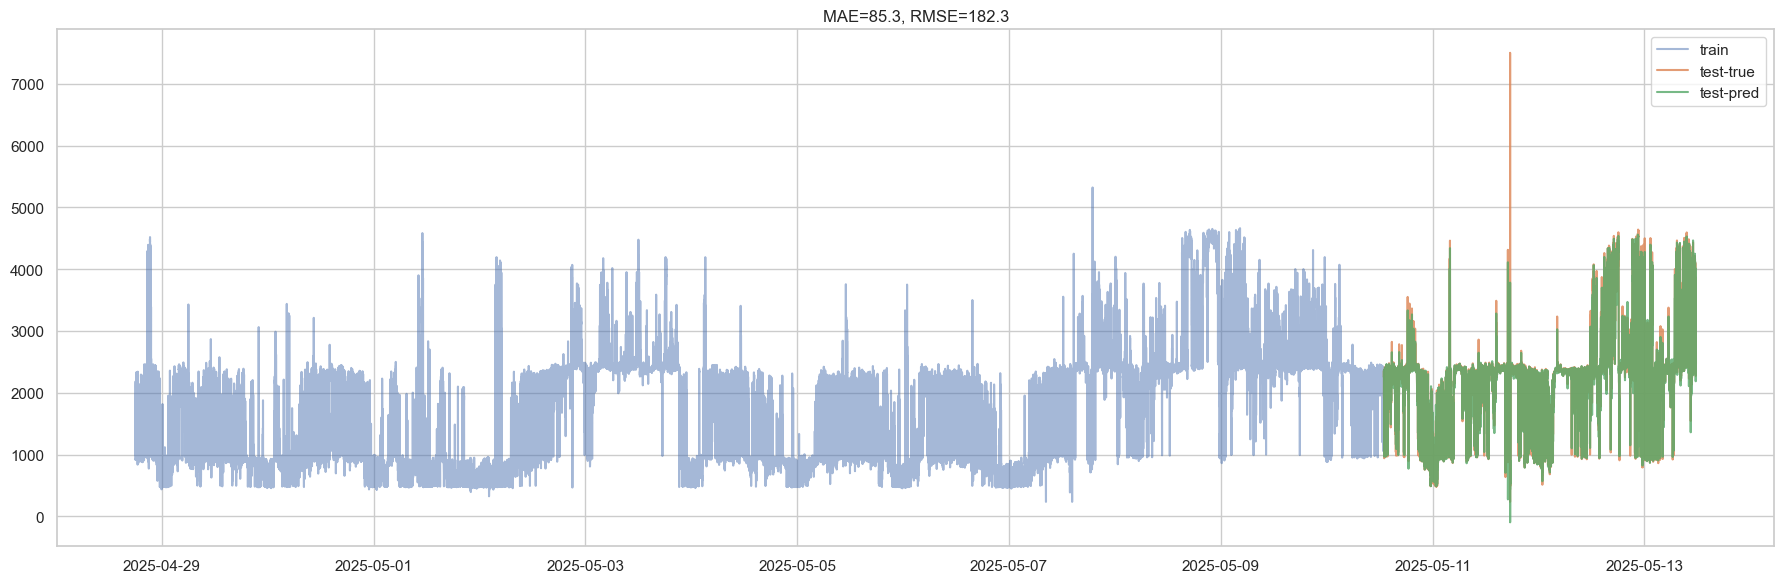

In [51]:
# инициализируем — можно менять lags/roll_windows/test_size
model = DelayForecastModel(
    horizon       = 5760,   # сутки = 24*60*60 / 15 = 5760 точек
    test_size     = 0.2,    # 80 % train, 20 % hold-out
    lags          = [1, 2, 4, 96, 192, 5760],
    roll_windows  = [96, 384, 5760]          # 24 мин, 1 ч, 1 сут
)

# fit + автоматически нарисует график «train / test-true / test-pred»
train_df, test_df = model.fit(
    df,
    target_col   = 'common_delay_p90',
    feature_cols = [],      # если есть другие метрики — впишите их названия здесь
    plot         = True
)

/var/folders/hz/g0q481y17153sdyxw9_71p380000gn/T/ipykernel_84414/599014918.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  future_index   = pd.date_range(


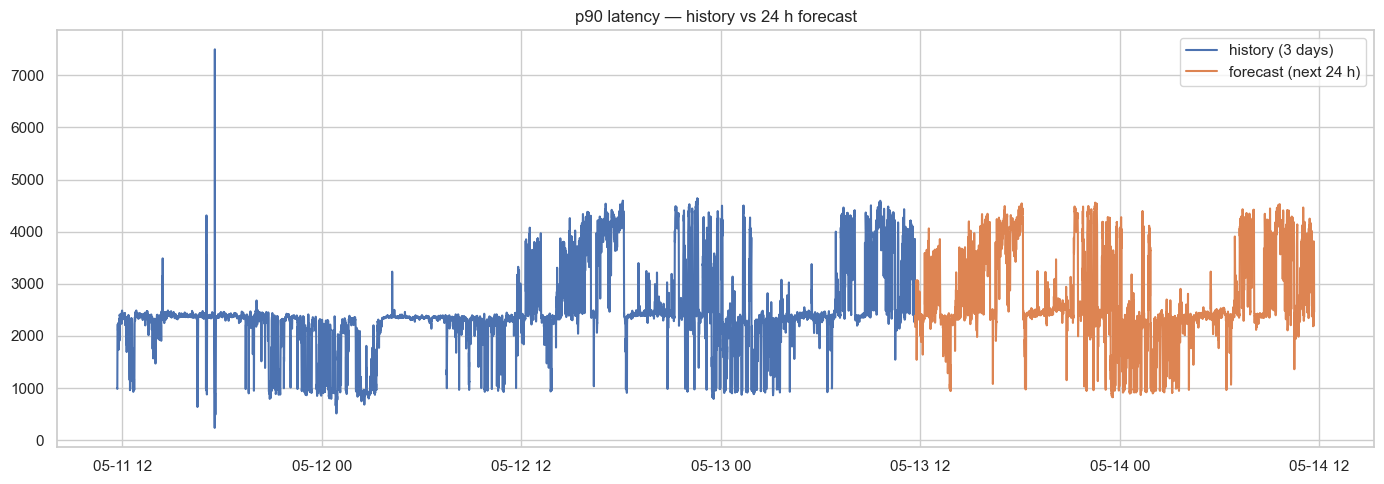

In [52]:
# берём последние (max(lags, roll_windows) + horizon) точек
history_needed = max(model.lags + model.roll_windows) + model.horizon
df_last = df.tail(history_needed)

# готовим фичи и предсказываем
df_future = model.prepare_future(df_last, 'common_delay_p90')

y_hat_next_day = model.predict(df_future)[-model.horizon:]
future_index   = pd.date_range(
    start=df.index[-1] + pd.Timedelta(seconds=15),
    periods=model.horizon,
    freq='15S'
)

# ----- визуализация прогноза -----
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(df_last.index[-3*5760:], df_last['common_delay_p90'].iloc[-3*5760:], label='history (3 days)')
plt.plot(future_index, y_hat_next_day, label='forecast (next 24 h)')
plt.legend()
plt.title('p90 latency — history vs 24 h forecast')
plt.tight_layout()
plt.show()


## 2. Код-шаблоны для подробного анализа



*** Hold-out metrics ***
           value
MAE    85.267321
RMSE  182.278325
MAPE    4.409726

MAE by day:
         date        None
0  2025-05-10   63.045246
1  2025-05-11   69.087277
2  2025-05-12   93.815136
3  2025-05-13  121.949880


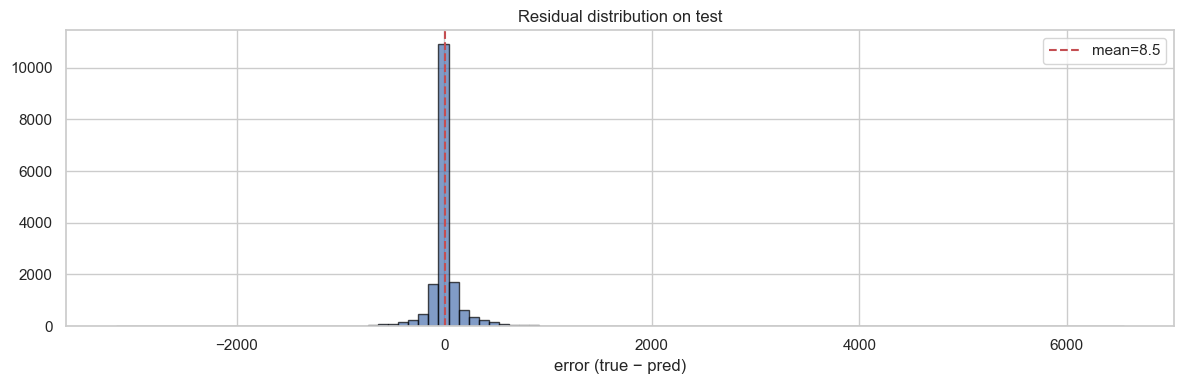

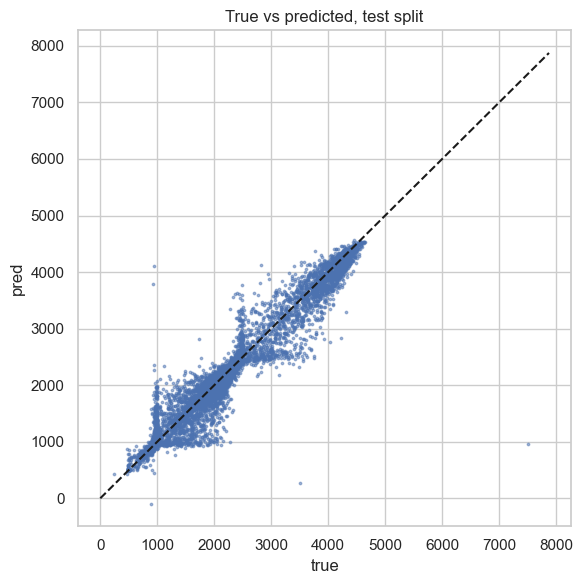

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_absolute_percentage_error)

# ---------------------------------------------------
# 2.1  получить true & pred на тесте
# ---------------------------------------------------
#  полный список признаков, который модель видела
feat_cols = (
    model.lags_feat_names_
    + model.roll_feat_names_
    + model.cat_features
)

# 1. истинные значения и прогноз
test_true = test_df['common_delay_p90']
test_pred = pd.Series(
    model.model.predict(test_df[feat_cols]),
    index=test_true.index,
    name='pred'
)

# 2. остатки
resid = test_true - test_pred


# ---------------------------------------------------
# 2.2  сводные метрики
# ---------------------------------------------------
metrics = {
    "MAE" : mean_absolute_error(test_true, test_pred),
    "RMSE": np.sqrt(mean_squared_error(test_true, test_pred)),
    "MAPE": mean_absolute_percentage_error(test_true, test_pred) * 100
}
metrics_df = pd.DataFrame([metrics]).T.rename(columns={0: "value"})
print("\n*** Hold-out metrics ***")
print(metrics_df)

# ---------------------------------------------------
# 2.3  метрики по суткам
# ---------------------------------------------------
daily = pd.concat([test_true, test_pred], axis=1)
daily['date'] = daily.index.date
# ежедневные метрики без предупреждения
daily_mae = (daily
             .groupby('date', as_index=False, observed=True)
             .apply(lambda g: mean_absolute_error(g['common_delay_p90'], g['pred']),
                    include_groups=False))
print("\nMAE by day:")
print(daily_mae.tail())

# ---------------------------------------------------
# 2.4  распределение ошибок
# ---------------------------------------------------
plt.figure(figsize=(12,4))
plt.hist(resid, bins=100, alpha=.7, edgecolor='black')
plt.axvline(resid.mean(), color='r', linestyle='--', label=f"mean={resid.mean():.1f}")
plt.title("Residual distribution on test")
plt.xlabel("error (true − pred)")
plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------------------------------
# 2.5  true vs pred scatter
# ---------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(test_true, test_pred, s=3, alpha=0.5)
lim = [0, max(test_true.max(), test_pred.max())*1.05]
plt.plot(lim, lim, 'k--')
plt.xlabel("true"); plt.ylabel("pred")
plt.title("True vs predicted, test split")
plt.tight_layout(); plt.show()


## 3. Feature Importance (какие лаги реально работают)

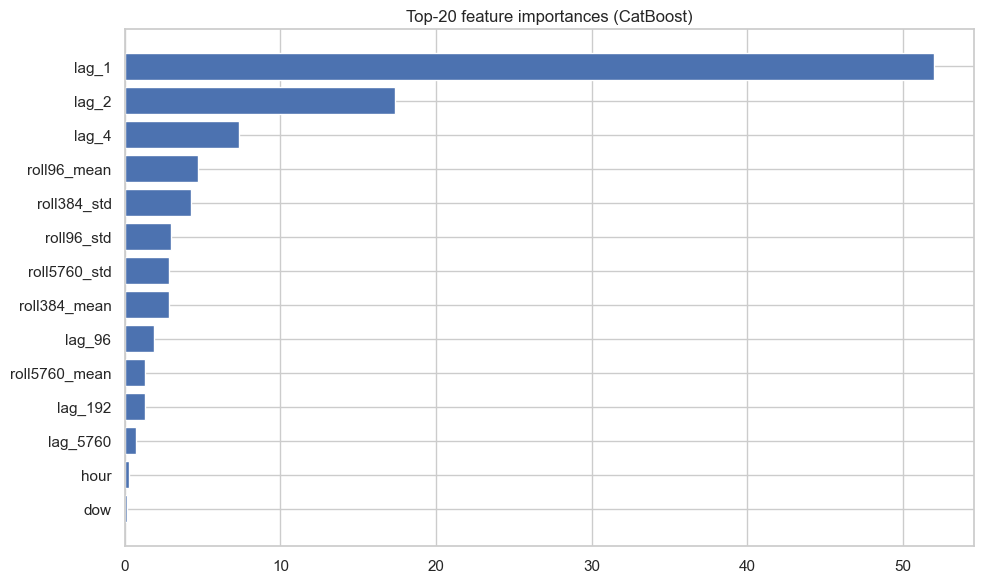

In [59]:
feat_names = (
    model.lags_feat_names_
    + model.roll_feat_names_
    + model.cat_features
)
importances = model.model.get_feature_importance(
    type='FeatureImportance'
)
imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(imp_df.feature.head(20)[::-1], imp_df.importance.head(20)[::-1])
plt.title("Top-20 feature importances (CatBoost)")
plt.tight_layout(); plt.show()


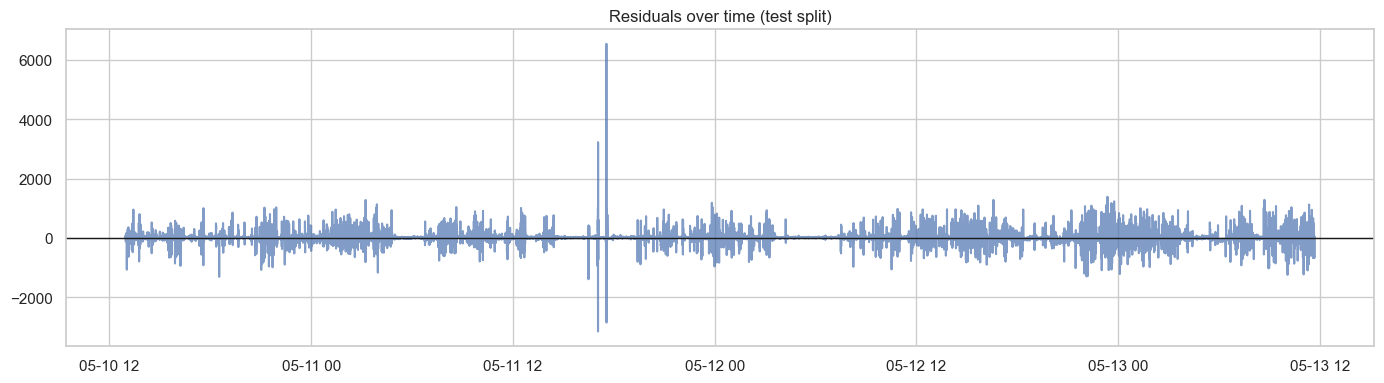

In [60]:
plt.figure(figsize=(14,4))
plt.plot(resid.index, resid, alpha=0.7)
plt.title("Residuals over time (test split)")
plt.axhline(0, color='k', lw=1)
plt.tight_layout(); plt.show()
